# Load librarys

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

# Load the images and create neural network model with TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import matplotlib.pyplot as plt

### Get Data and associate Labes


In [ ]:
# Dataset
import zipfile

# Extract the dataset
z = zipfile.ZipFile('C:/Git_Repos/NeuNe/archive.zip')

# Extract all the contents of zip file in current directory to a new folder named 'data'
z.extractall('data')


In [ ]:
label_csv = pd.read_csv('data/Brain Tumor.csv')
label_csv.head()

image_folder = 'data/Brain Tumor/Brain Tumor'

# Save all the images to a folder named tumor and non_tumor
tumor_folder = 'data/labeled/tumor'
non_tumor_folder = 'data/labeled/non_tumor'

# Create the folders
os.makedirs(tumor_folder, exist_ok=True)
os.makedirs(non_tumor_folder, exist_ok=True)

# Copy the images to the folders
for index, row in label_csv.iterrows():
    image_path = os.path.join(image_folder, row['Image']+ '.jpg')
    if row['Class'] == 1:
        shutil.copy(image_path, tumor_folder)
    else:
        shutil.copy(image_path, non_tumor_folder)

# Check the number of images in each folder
print('Number of images in tumor folder:', len(os.listdir(tumor_folder)))
print('Number of images in non_tumor folder:', len(os.listdir(non_tumor_folder)))

# Display a few images from each folder
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(tumor_folder, os.listdir(tumor_folder)[i])))
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(non_tumor_folder, os.listdir(non_tumor_folder)[i])))
    plt.title('Non Tumor')
    plt.axis('off')
plt.show()


#### Load Data with tensorflow as pipline

Found 3762 files belonging to 2 classes.


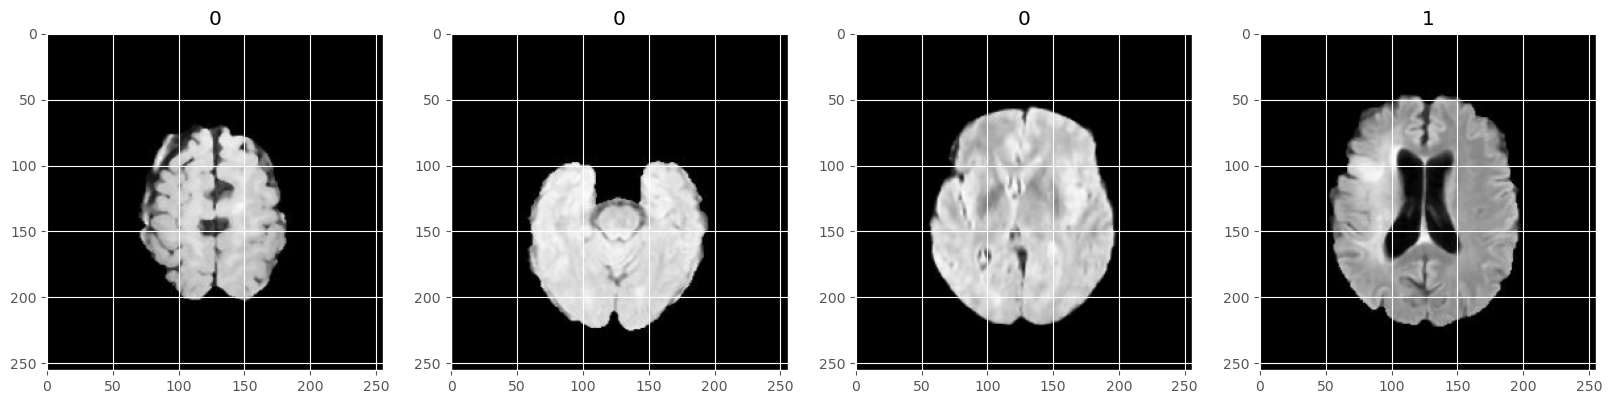

In [2]:
# building data pipeline
data = tf.keras.utils.image_dataset_from_directory('data/labeled')


# create a data iterator
data_iterator = data.as_numpy_iterator()

# creat a batch 
batch = data_iterator.next()

# images represented as numpy arrays
batch[0].shape

batch[1]

# plot the batch to see which class belongs to which image
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])



 Class 1 is Tumor
 
 Class 2 is no Tumor

# Preprocessing

In [3]:
# pincip of scaling
# Just for testing don't run this code
"""
scaled = batch[0] / 255
scaled.max()
"""

'\nscaled = batch[0] / 255\nscaled.max()\n'

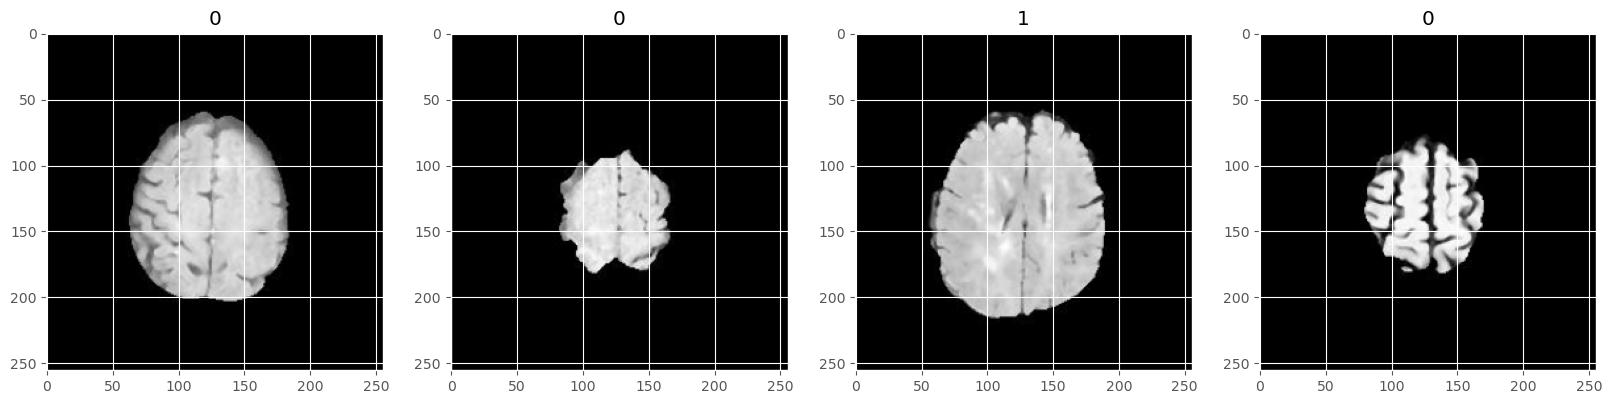

In [4]:
# scale the data pipline on the fly 
data = data.map(lambda x, y: (x/255, y))

scaled_interator = data.as_numpy_iterator()
scaled_batch = scaled_interator.next()
scaled_batch[0].min()

# display the batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

Split Data

In [5]:
# decide the size of the train, validation and test datasets
print(len(data))
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

train_size + val_size + test_size

118


118

In [6]:
# split the data into train, validation and test
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

print(len(train), len(val), len(test))


82 24 12


# Data Augementation

In [7]:
# Define data augmentation only for training
train_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3))
])

# Apply augmentation to the training dataset
train = train.map(lambda x, y: (train_data_augmentation(x, training=True), y))


# Modeling 

In [8]:
batch[0].shape

(32, 256, 256, 3)

Epoch 1/10


c:\Users\fr3m3\anaconda3\envs\NeuNe_tensor\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 544ms/step - accuracy: 0.6166 - loss: 0.6491 - val_accuracy: 0.8203 - val_loss: 0.4797
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 550ms/step - accuracy: 0.7834 - loss: 0.4861 - val_accuracy: 0.7695 - val_loss: 0.4861
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 540ms/step - accuracy: 0.8135 - loss: 0.4119 - val_accuracy: 0.8464 - val_loss: 0.3804
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 541ms/step - accuracy: 0.8380 - loss: 0.3655 - val_accuracy: 0.8268 - val_loss: 0.4125
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 541ms/step - accuracy: 0.8438 - loss: 0.3486 - val_accuracy: 0.8477 - val_loss: 0.3730
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 545ms/step - accuracy: 0.8388 - loss: 0.3599 - val_accuracy: 0.8477 - val_loss: 0.3753
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 542ms/step - accuracy: 0.8330 - loss: 0.3691 - val_accuracy: 0.8568 - val_loss: 0.3890


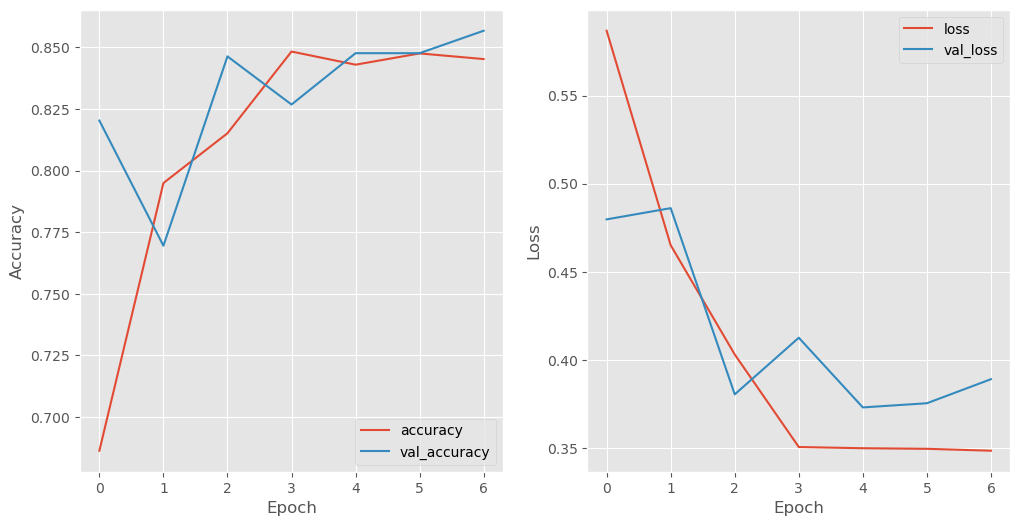

In [9]:
# Create the model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(train, validation_data=val, epochs=10, callbacks=[early_stopping])

# Plot the accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Performance

In [10]:
# Messures used for classification problems, precision, recall and accuracy. 
# Establish instance of precision, recall and accuracy
pre =  Precision()
re = Recall()
acc = BinaryAccuracy()

In [11]:
len(test)

12

In [12]:
# Iterate over the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Reshape yhat if necessary to match the dimensions of y
    if yhat.shape[-1] == 1:
        yhat = tf.squeeze(yhat, axis=-1)  # Squeeze the last dimension

    # Update metric states
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)  # Here, we correctly use BinaryAccuracy

# Print the results after processing all batches
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Precision: 0.9275362491607666, Recall: 0.7485380172729492, Accuracy: 0.8599537014961243


Somethings not correct with Accuracy: 0.16331450641155243, don't know what 

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step


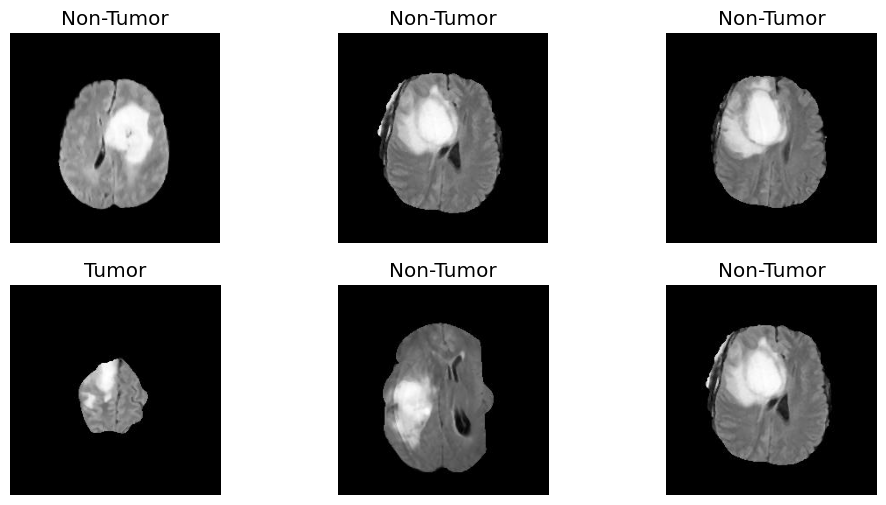

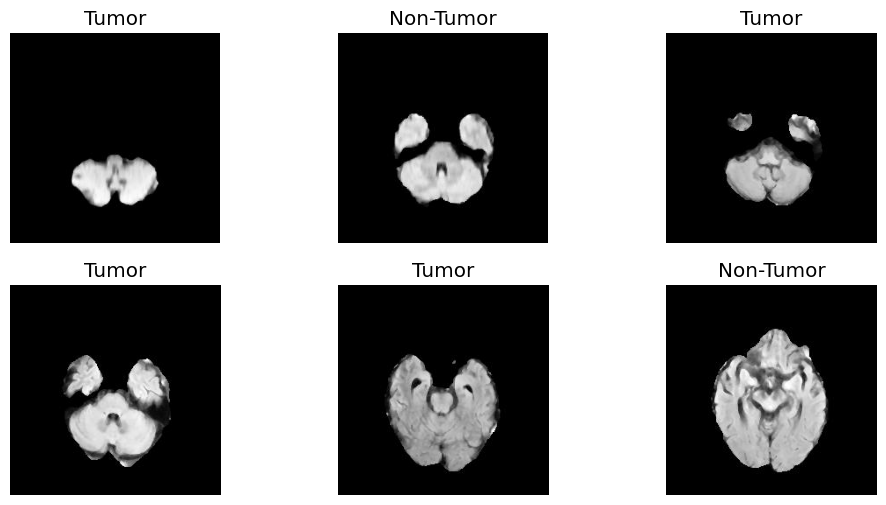

In [93]:
# Predictions on test dataset
predictions = model.predict(test)  # Use the 'test' dataset directly

# Display predictions for images from tumor_folder
plt.figure(figsize=(12, 6))
for i in range(6):
    # Load images directly from the folder
    img_path = os.path.join(tumor_folder, os.listdir(tumor_folder)[i])
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Tumor' if predictions[i] > 0.5 else 'Non-Tumor')
    plt.axis('off')
plt.show()

# Display predictions for images from non_tumor_folder
plt.figure(figsize=(12, 6))
for i in range(6):
    # Load images directly from the folder
    img_path = os.path.join(non_tumor_folder, os.listdir(non_tumor_folder)[i])
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Tumor' if predictions[i+6] > 0.5 else 'Non-Tumor')
    plt.axis('off')
plt.show()

# Save the Model

In [20]:
# Create the model folder
os.makedirs('model', exist_ok=True)

# Save the model
model.save(os.path.join('model', 'brain_tumor_classifier.keras'))

# save the model in the h5 format
model.save('model/brain_tumor_classifier.h5')